# Preparation

In [1]:
#@title Import statements

import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc3


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import ipython_genutils

In [3]:
#@title Import plotting functions

import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
from collections import Counter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#@title (Misc) GDrive integration
import os
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Feature Engineering

## Read dataset from CSV file

In [0]:
url = 'https://raw.githubusercontent.com/hamdiibnizhar/bangkit-w05-winequality/master/datasets/winequality-red.csv'
df = pd.read_csv(url)

## Dataset characteristics and Imputation

In [6]:
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Here we explore what our dataset has to offer.

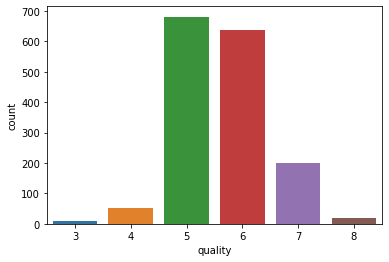

In [7]:
df['quality'].value_counts(sort=False)
sns.countplot(x='quality', data=df)

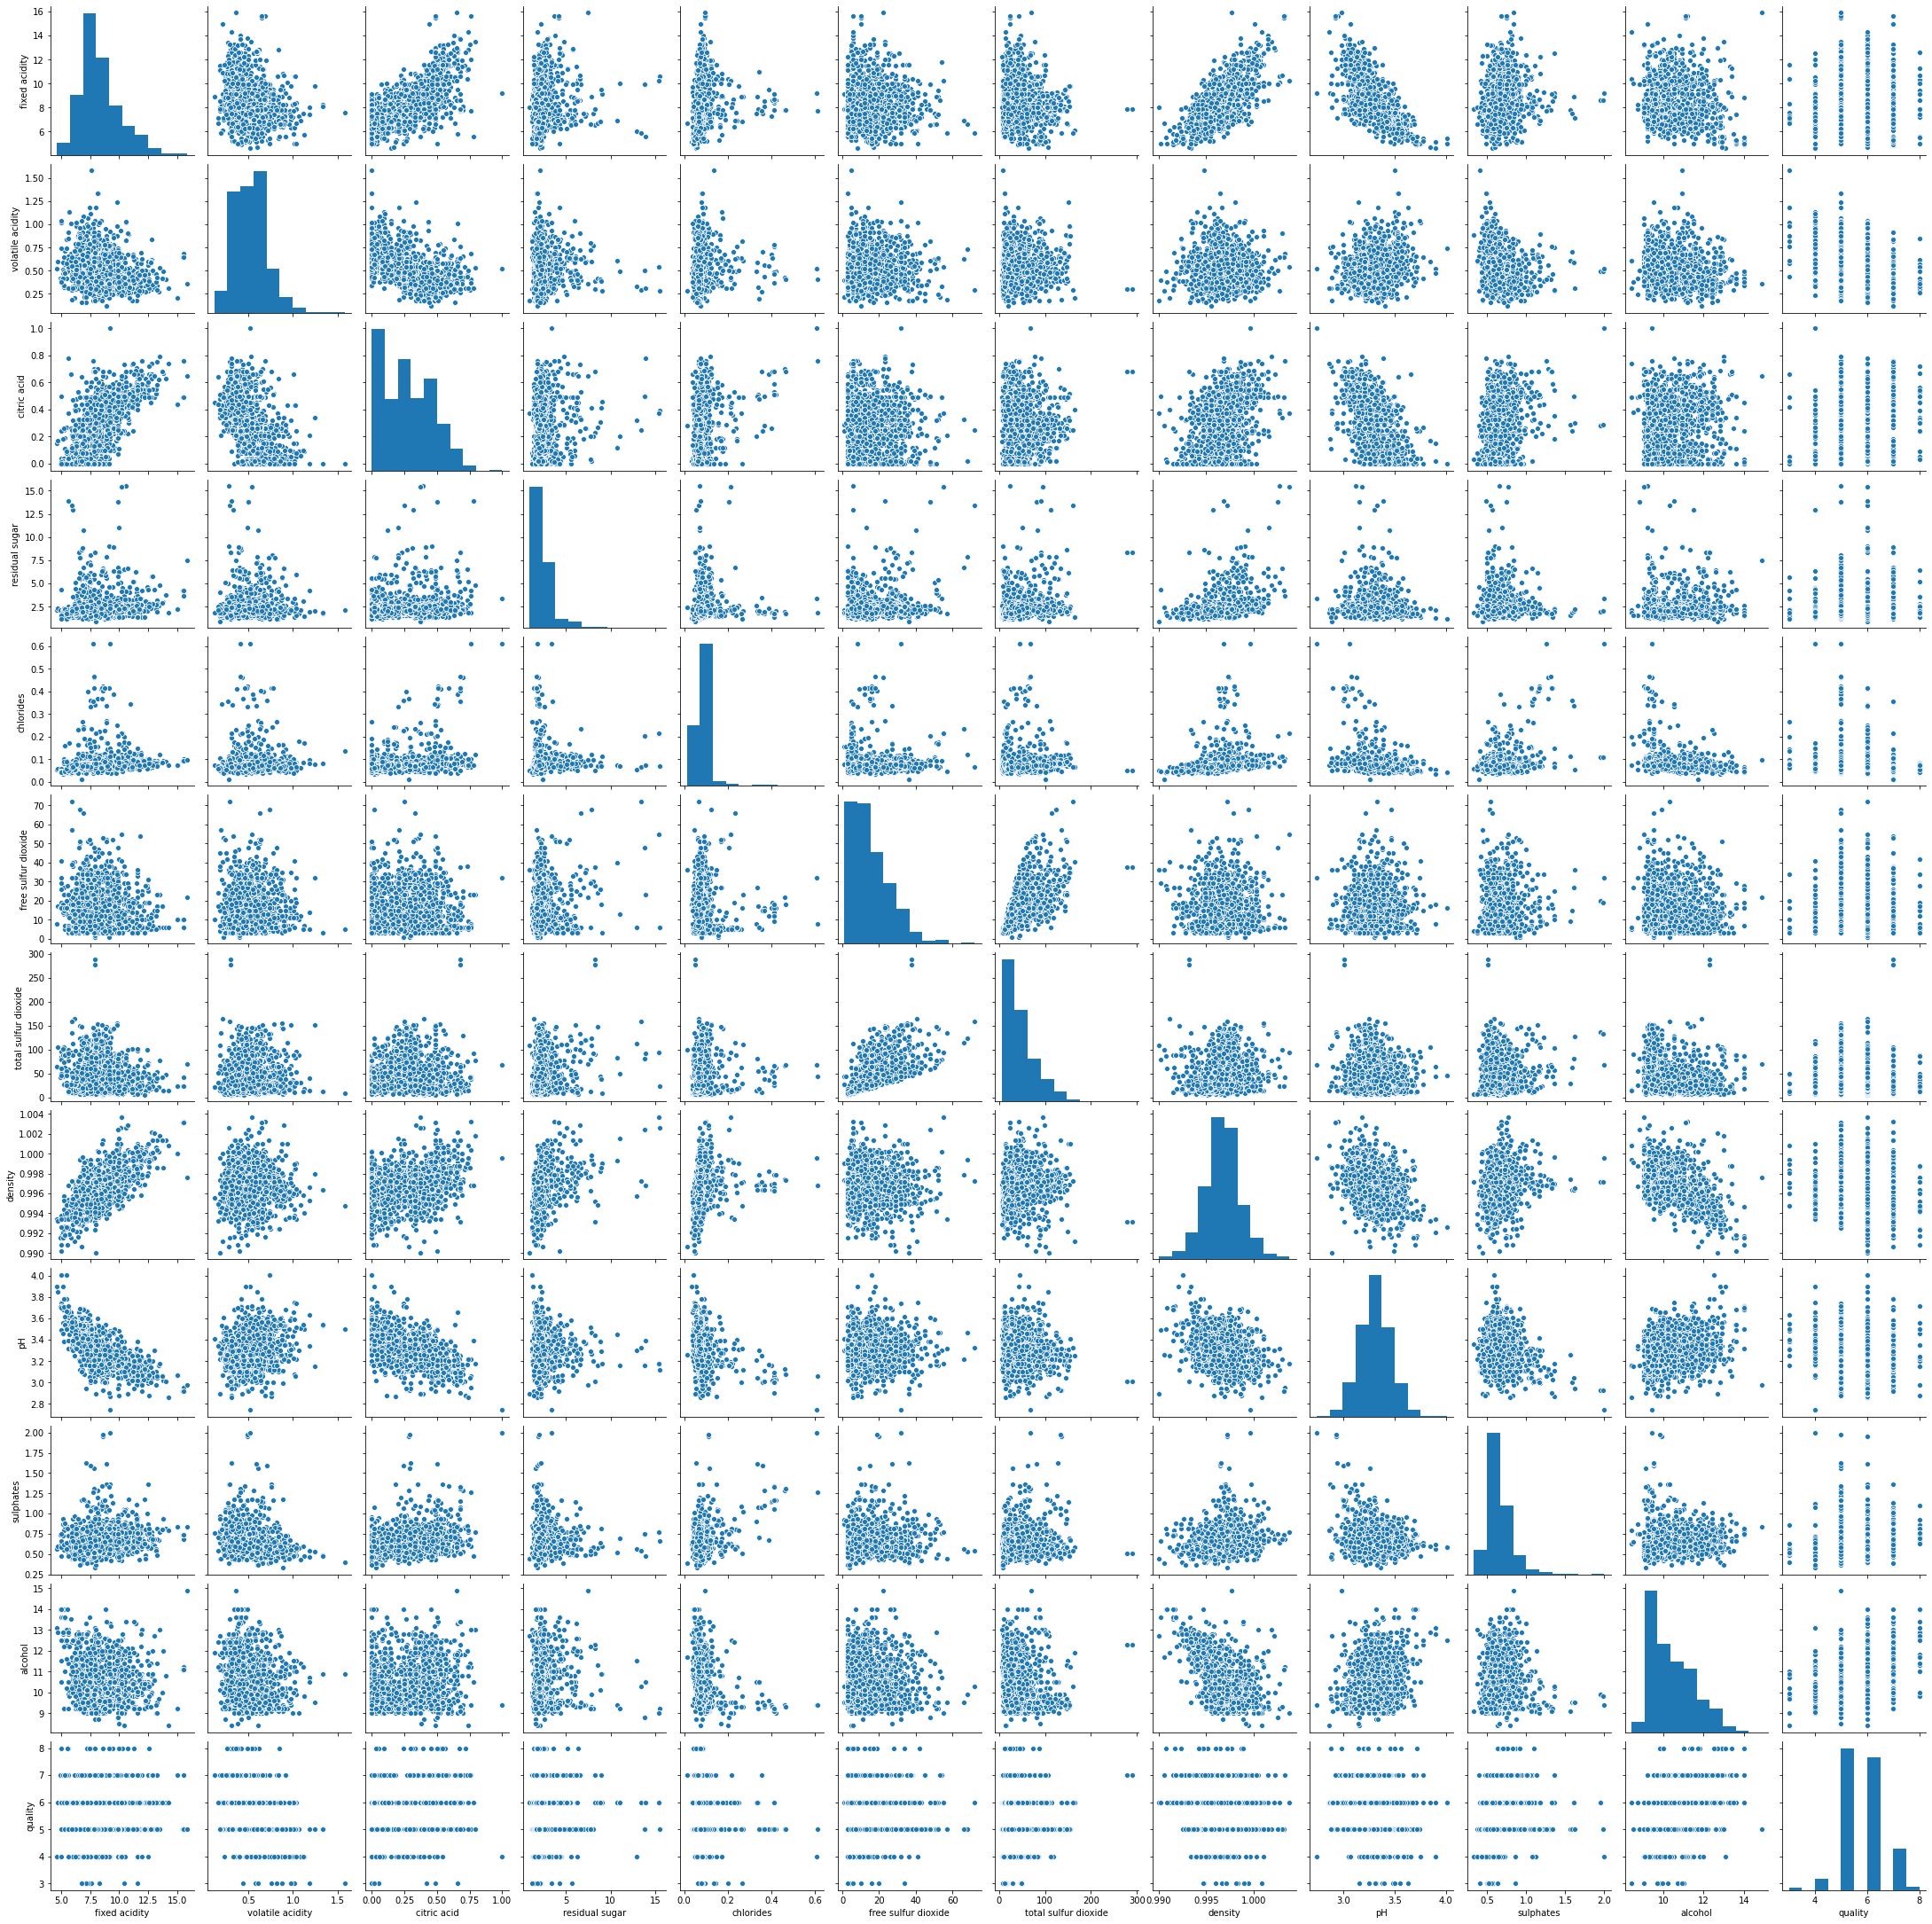

In [8]:
sns.pairplot(df)

In [0]:
def analizeSpreadData(originalData):
  mean = originalData.mean()
  median = originalData.median()
  mode = originalData.mode()[0]

  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (3, 3)})
  sns.boxplot(originalData, ax=ax_box, color="y", width=10)
  ax_box.axvline(mean, color='r', linestyle='--')
  ax_box.axvline(median, color='g', linestyle='-')
  ax_box.axvline(mode, color='b', linestyle='-')

  sns.distplot(originalData, ax=ax_hist, hist=False, color="m", kde_kws={"shade": True})
  ax_box.axvline(mean, color='r', linestyle='--')
  ax_box.axvline(median, color='g', linestyle='-')
  ax_box.axvline(mode, color='b', linestyle='-')

  plt.legend({'Mean':mean,'Median':median,'Mode':mode})

  ax_box.set(xlabel='')
  plt.show()

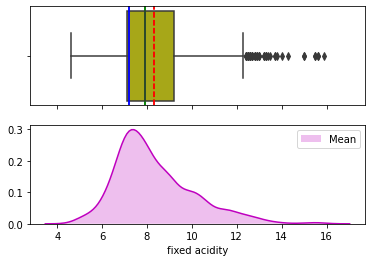

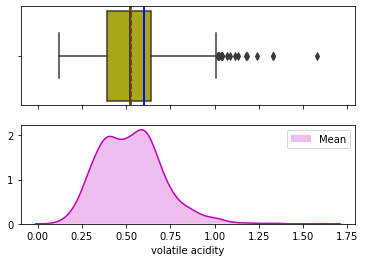

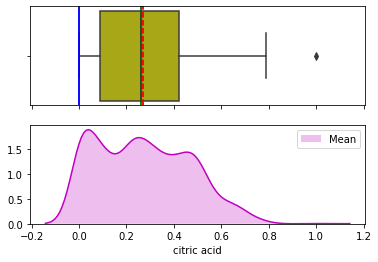

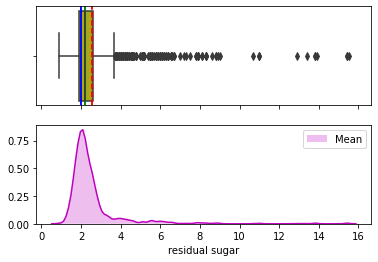

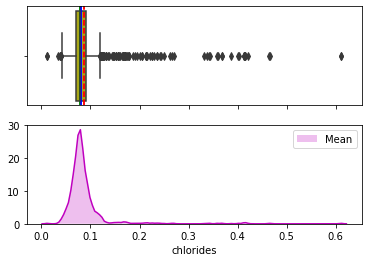

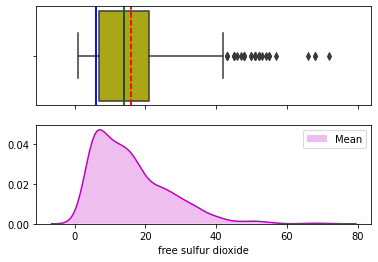

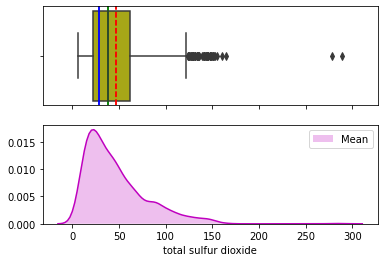

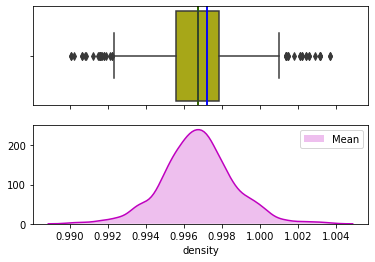

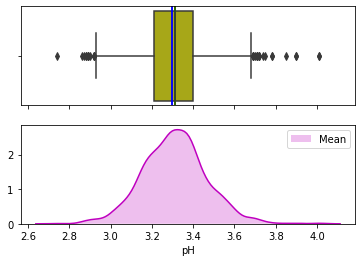

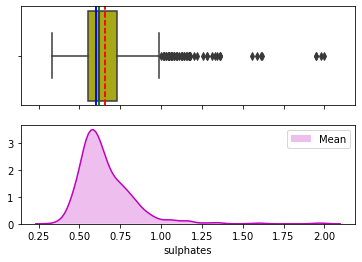

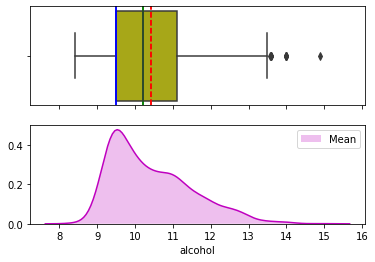

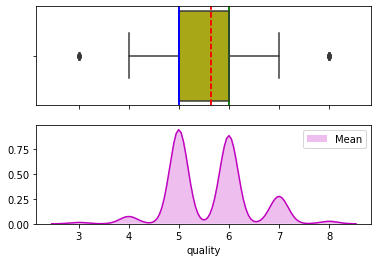

In [10]:
for columns in df.columns:
  analizeSpreadData(df[columns])

## Handling Outlier
to 95%

In [0]:
def outlierHandler(data):
  temp_df = pd.DataFrame()
  print("data before removing outlier :", data.shape)
  for column in data.columns:
    if column == 'quality':
      continue
    factor = 2
    upper_lim = data[column].mean () + data[column].std () * factor
    lower_lim = data[column].mean () - data[column].std () * factor
    
    # IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
    # upper_lim = data[column].quantile(0.75) + 1.5*IQR
    # lower_lim = data[column].quantile(0.25) - 1.5*IQR

    temp_df = data[(data[column] < upper_lim) & (data[column] > lower_lim)]
  print("data after removing outlier :", temp_df.shape)
  return temp_df

data before removing outlier : (1599, 12)
data after removing outlier : (1529, 12)


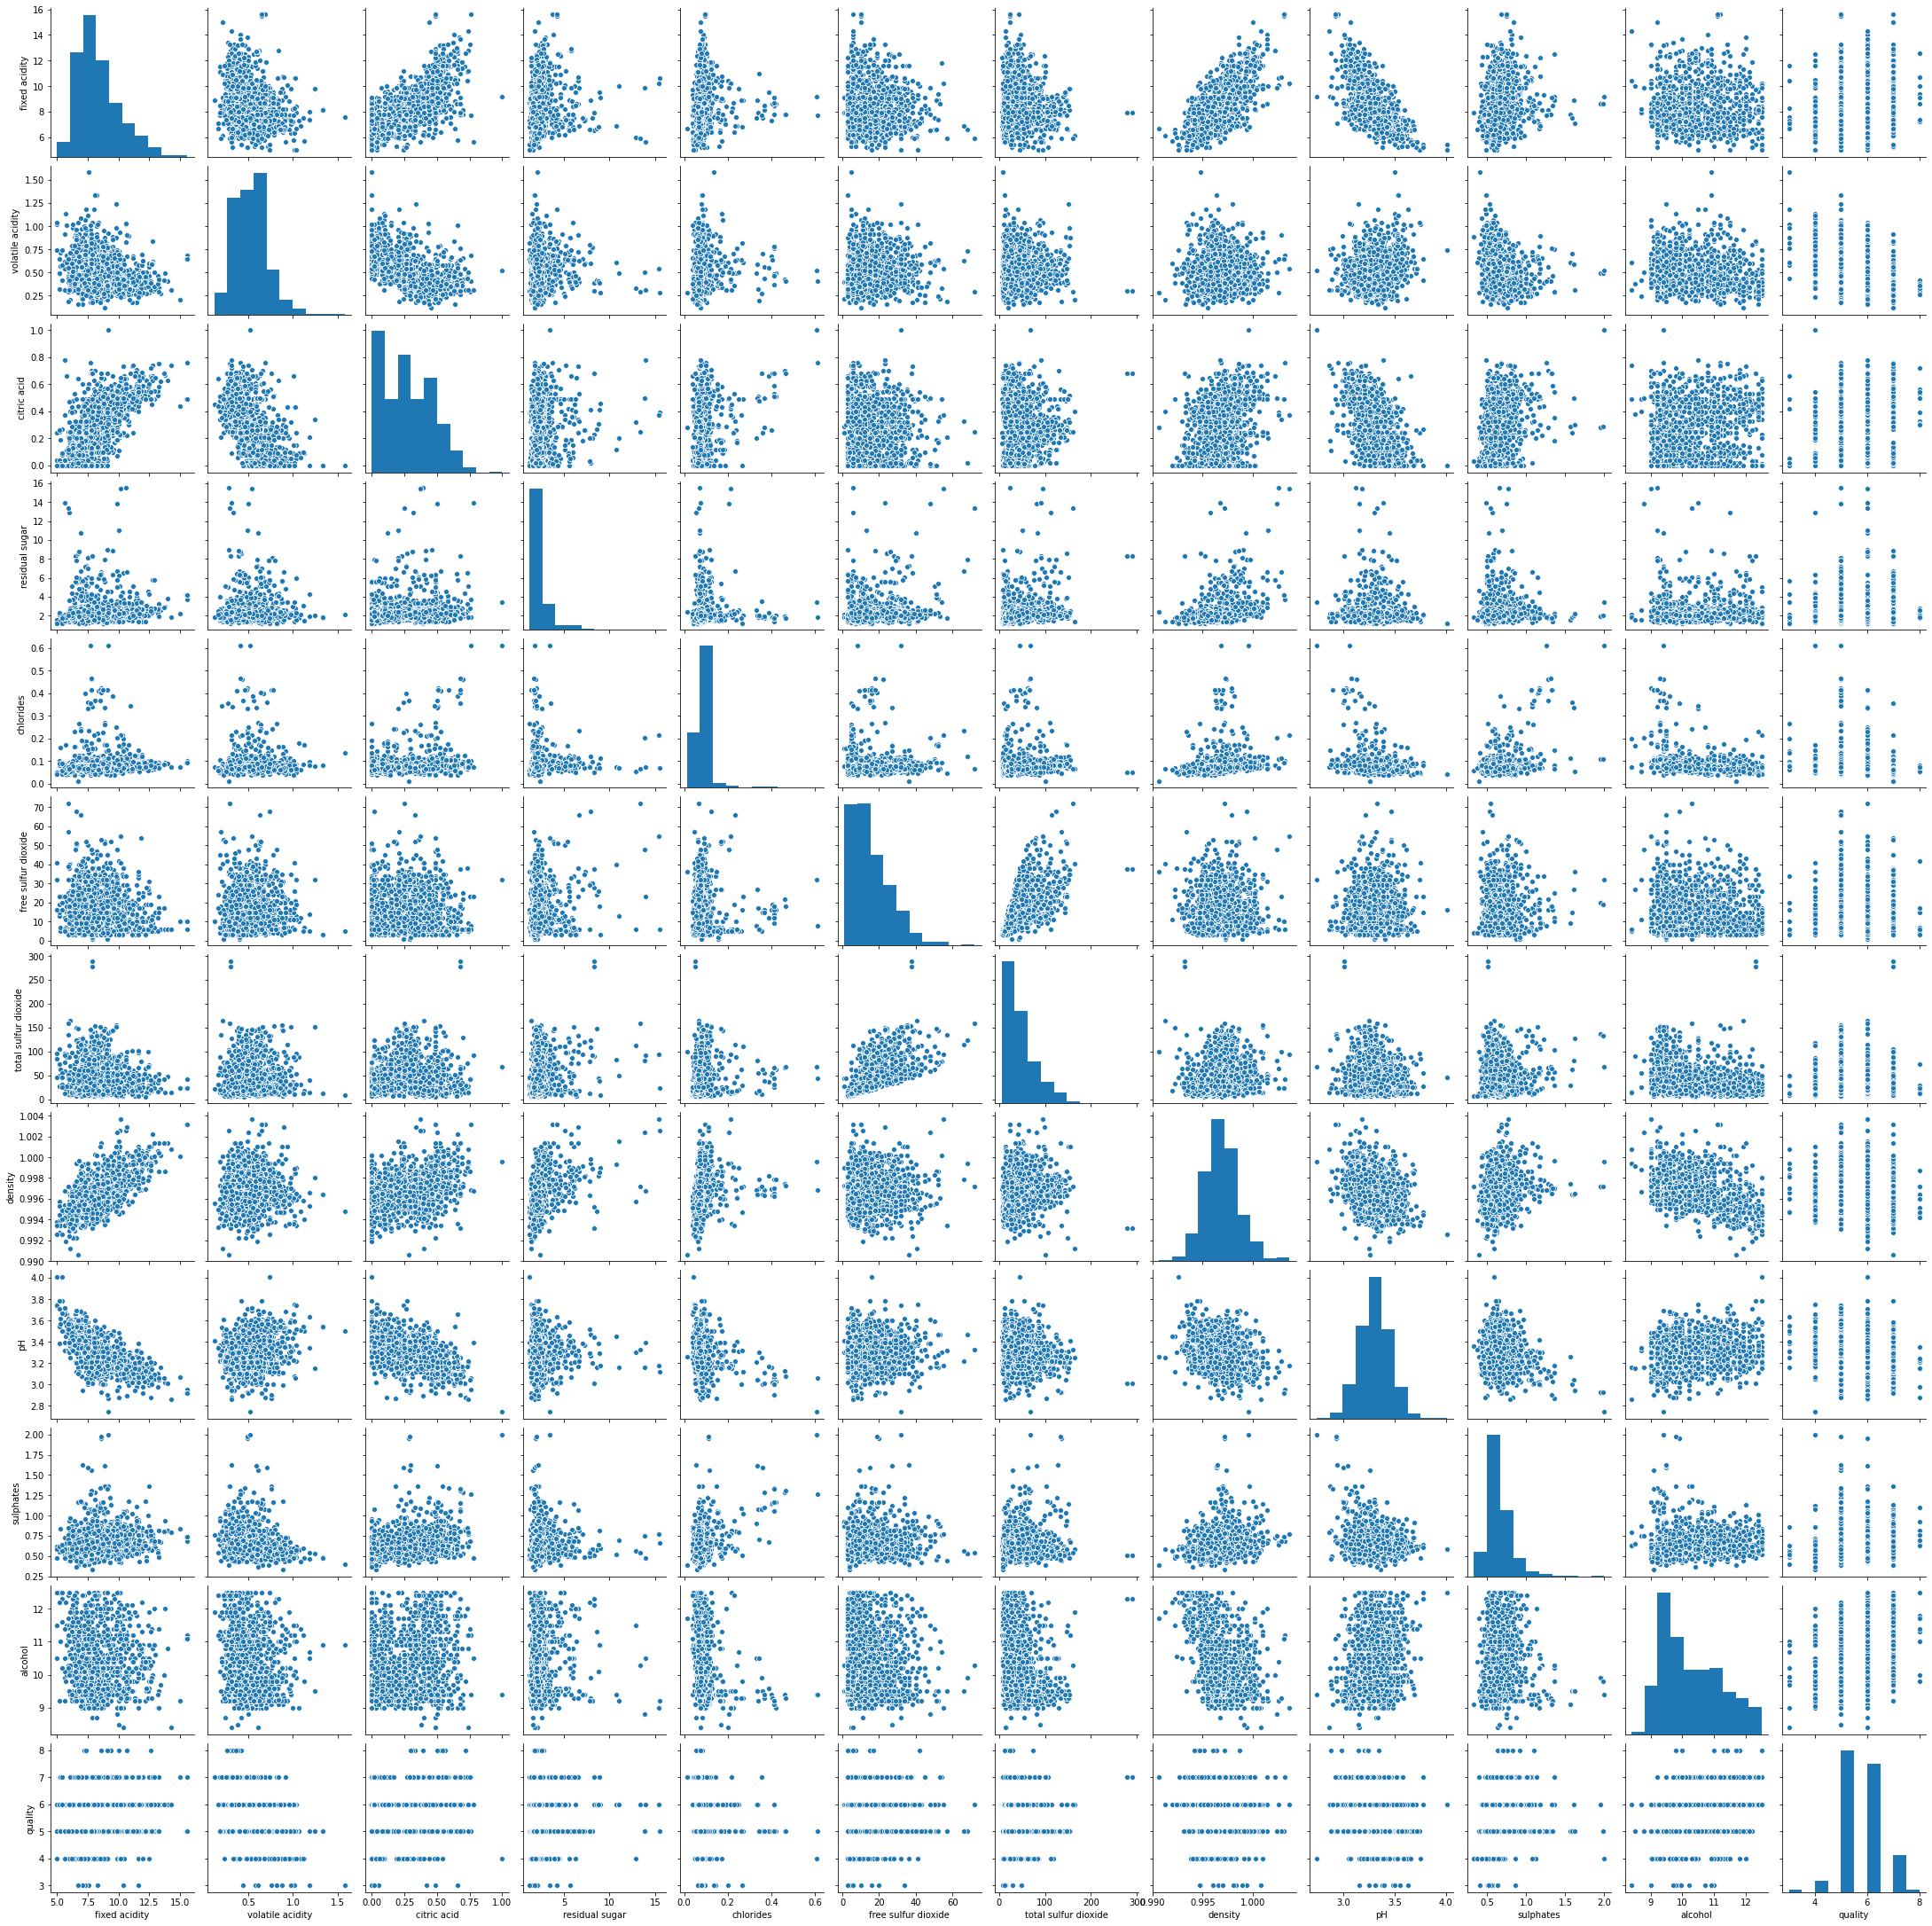

In [12]:
df = outlierHandler(df)
sns.pairplot(df)

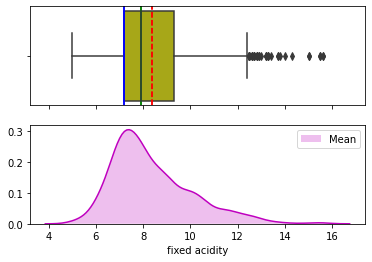

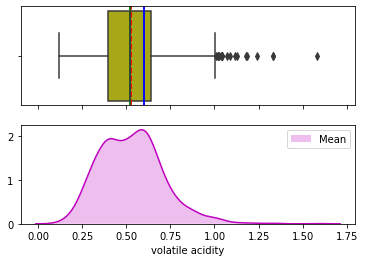

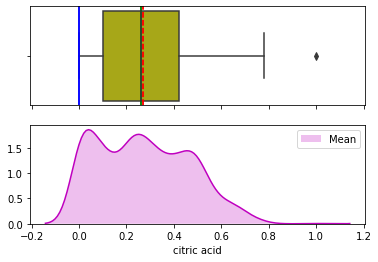

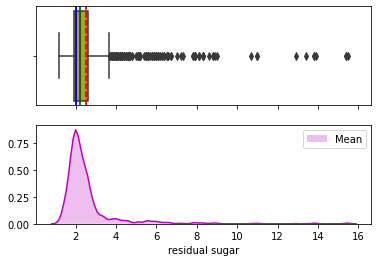

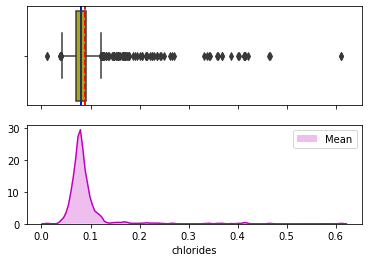

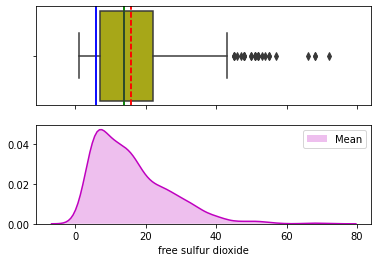

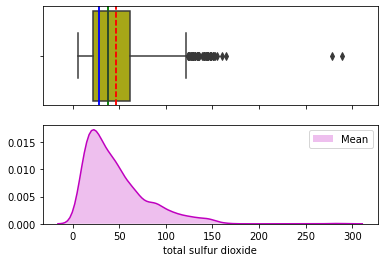

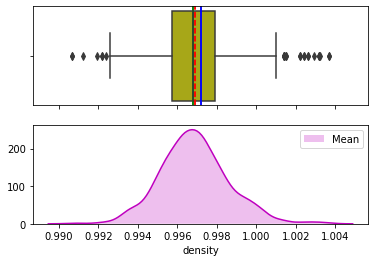

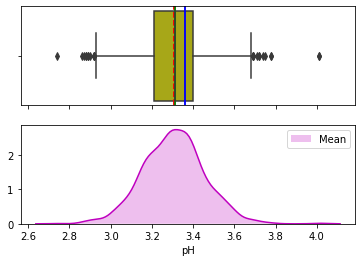

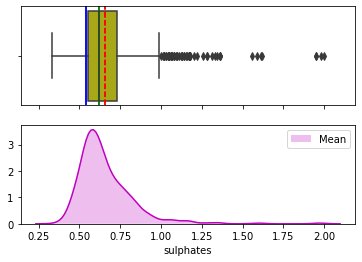

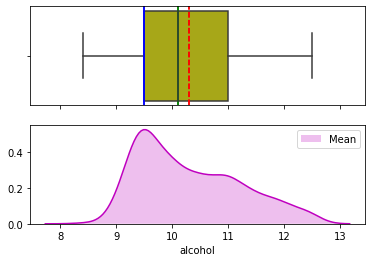

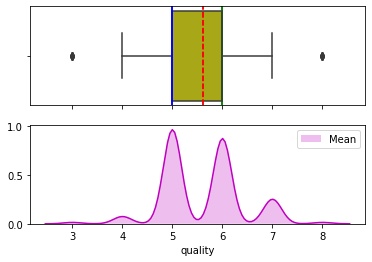

In [13]:
for columns in df.columns:
  analizeSpreadData(df[columns])

## Skewing and Binning

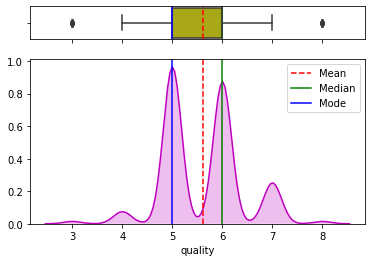

In [14]:
mean = df["quality"].mean()
median = df["quality"].median()
mode = df["quality"].mode()[0]

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})

sns.boxplot(df["quality"], ax=ax_box, color="y", width=10)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')
ax_box.axvline(mode, color='b', linestyle='-')

sns.distplot(df["quality"], ax=ax_hist, hist=False, color="m", kde_kws={"shade": True})
ax_hist.axvline(mean, color='r', linestyle='--')
ax_hist.axvline(median, color='g', linestyle='-')
ax_hist.axvline(mode, color='b', linestyle='-')

plt.legend({'Mean':mean,'Median':median,'Mode':mode})

ax_box.set(xlabel='')
plt.show()

In [15]:
df["quality"].skew()

0.16674936008307523

## Group quality to 3 categories

Based on the spread of mean and median, to simplify our problem, we want to divide 0-10 quality scale into 3 rating categories: `low`, `moderate/average` and `high/good` quality. These categories should be more practical for real-world use.

We determine that:
- wine quality of `0 - 4` belongs to `low` rating (label: `0`)
- wine quality of `5 - 6` belongs to `moderate/average` rating (label: `1`)
- wine quality of `>= 7` belongs to `high/good` rating (label: `2`)

In [16]:
# divide quality to rating
# 0 < q < 5: 0; 5 <= q < 7: 1; q >= 7: 2;

dataset = df.copy()
dataset['Rating'] = dataset['quality'].map(lambda x: 0 if x < 5 else 1 if x < 7 else 2)

dataset.pop("quality")
dataset['Rating'].value_counts()

1    1281
2     186
0      62
Name: Rating, dtype: int64

# Feature Selection

## Pearson Correlation

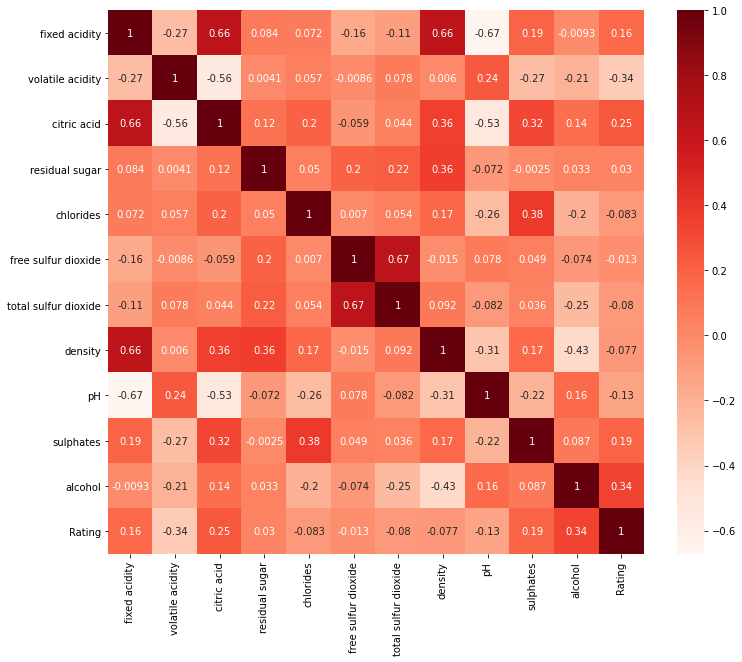

In [17]:
plt.figure(figsize=(12,10))
cor = dataset.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [18]:
cor_target = abs(cor["Rating"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.13]
print(relevant_features)
selected_features1 = list(relevant_features.to_dict())
selected_features1

fixed acidity       0.164087
volatile acidity    0.344105
citric acid         0.248245
pH                  0.131969
sulphates           0.190771
alcohol             0.336749
Rating              1.000000
Name: Rating, dtype: float64


['fixed acidity',
 'volatile acidity',
 'citric acid',
 'pH',
 'sulphates',
 'alcohol',
 'Rating']

## Recursive Feature Elimination

In [19]:
X = dataset.copy()
Y = X.pop('Rating')
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 7)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  

#Fitting the data to model
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)
rfe.support_

[False  True  True False  True False False  True  True  True  True]
[2 1 1 3 1 4 5 1 1 1 1]


array([False,  True,  True, False,  True, False, False,  True,  True,
        True,  True])

In [20]:
from sklearn.svm import SVC
from sklearn.svm import SVR
# model = SVC(gamma='auto')
model = SVR(kernel="linear")
rfe = RFE(model, 11)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  
#Fitting the data to model
model.fit(X_rfe,Y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1]


In [21]:
nof_list=np.arange(1,13)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 0)
    # model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 7
Score with 7 features: 0.096184


In [0]:
cols = list(X.columns)

#Initializing RFE model
rfe = RFE(model, nof)             

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,Y)  

#Fitting the data to model
model.fit(X_rfe,Y)              

temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
selected_features_rfe.sort_values()
# print(selected_features_rfe)
selected_features2 = selected_features_rfe.to_list()
selected_features2.append('Rating')

## Intersection List

In [23]:
def intersectionList(lists1, lists2):
  temp_list = []
  for list1 in lists1:
    for list2 in lists2:
      if list1 == list2:
        temp_list.append(list1)
  return temp_list

selected_features_intersect = intersectionList(selected_features1, selected_features2)
selected_features_intersect

['volatile acidity', 'citric acid', 'pH', 'sulphates', 'alcohol', 'Rating']

In [0]:
selected_features_dataset = dataset[selected_features_intersect]

# Data Transformation

## Create test data

We don't have test data available as is from the source, so we have to create it from the data pool.

We decided to train on 80% of the data, and make the rest 20% as the test data.

To avoid bias, we divide the train and test data with random sampling.

In [69]:
train_dataset = selected_features_dataset.sample(frac=0.8,random_state=0)
test_dataset = selected_features_dataset.drop(train_dataset.index)
train_dataset

volatile acidity  citric acid    pH  sulphates  alcohol  Rating
1429             0.180         0.40  3.33       0.93     11.3       1
531              0.380         0.49  3.16       0.61     10.3       1
9                0.500         0.36  3.35       0.80     10.5       1
407              0.390         0.66  3.18       0.63     10.8       2
489              0.390         0.40  3.34       0.75     10.2       1
...                ...          ...   ...        ...      ...     ...
865              0.635         0.07  3.51       0.54      9.7       1
987              0.360         0.30  3.44       0.50      9.4       1
1202             0.420         0.39  3.35       0.69     11.7       2
1085             0.480         0.08  3.12       0.49      9.6       1
1291             0.635         0.10  3.29       0.75     10.9       1

[1223 rows x 6 columns]

Statistics of the training set.

We will use values from this stats (mean, std) to normalize the data.

In [70]:
train_stats = train_dataset.describe()
train_stats.pop("Rating")
train_stats = train_stats.transpose()
train_stats

count       mean       std   min   25%    50%     75%    max
volatile acidity  1223.0   0.531500  0.183312  0.12  0.39   0.53   0.640   1.58
citric acid       1223.0   0.274849  0.196626  0.00  0.10   0.26   0.435   1.00
pH                1223.0   3.305159  0.150285  2.74  3.20   3.30   3.400   4.01
sulphates         1223.0   0.658790  0.172363  0.37  0.55   0.62   0.730   2.00
alcohol           1223.0  10.296688  0.921816  8.40  9.50  10.10  11.000  12.50

## Separate label and features

In [0]:
train_labels = train_dataset.pop('Rating')
test_labels = test_dataset.pop('Rating')

## Normalize values

On our attempt to see our dataset characteristics earlier, we see that range of the data varies.

For example, values of `fixed acidity` ranges from `4.6 - 15.9`, while `total sulfur dioxide` has a range of `6 - 62`. Meanwhile, `pH` values only range from `2.74` to `4.01`.

That this can cause  issues when training the model. Therefore, we convert each value of the features to its Z-score.

In [0]:
#standardization
def z_score_norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = z_score_norm(train_dataset)
normed_test_data = z_score_norm(test_dataset)

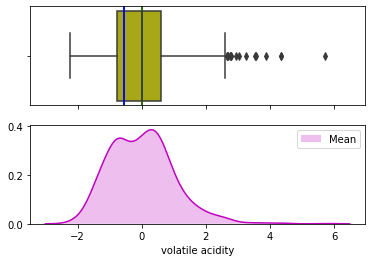

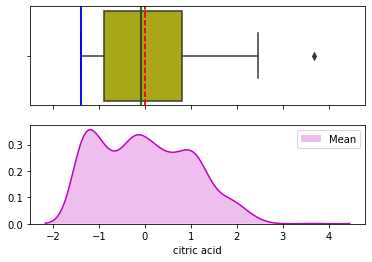

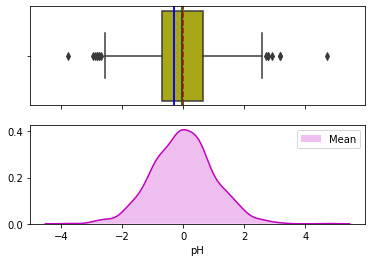

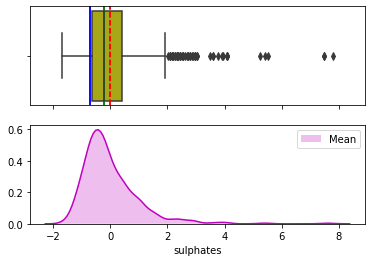

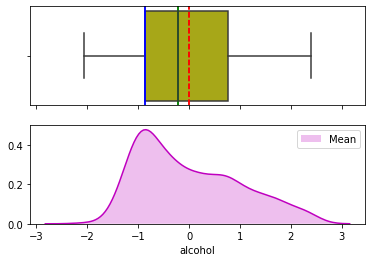

In [73]:
# show the boxplot to see the outlier
for columns in normed_train_data.columns:
  analizeSpreadData(normed_train_data[columns])

In [0]:
def lineGraphComparision(originalData, processedData):
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (3, 3)})
  sns.distplot(originalData, ax=ax_box, hist=False, color="y", kde_kws={"shade": True})
  sns.distplot(processedData, ax=ax_hist, hist=False, color="m", kde_kws={"shade": True})

def tableComparision(originalData, processedData, colName):
  temp_df = pd.DataFrame()
  newOriginalColName = colName + ' pre-scaling'
  newProcessedColName = colName +' post-scaling'
  temp_df[newOriginalColName] = originalData[colName].copy()
  temp_df[newProcessedColName] = processedData[colName].copy()
  display(temp_df.head(5))

volatile acidity pre-scaling  volatile acidity post-scaling
1429                          0.18                      -1.917497
531                           0.38                      -0.826462
9                             0.50                      -0.171840
407                           0.39                      -0.771910
489                           0.39                      -0.771910

citric acid pre-scaling  citric acid post-scaling
1429                     0.40                  0.636495
531                      0.49                  1.094218
9                        0.36                  0.433063
407                      0.66                  1.958804
489                      0.40                  0.636495

pH pre-scaling  pH post-scaling
1429            3.33         0.165289
531             3.16        -0.965892
9               3.35         0.298369
407             3.18        -0.832811
489             3.34         0.231829

sulphates pre-scaling  sulphates post-scaling
1429                   0.93                1.573482
531                    0.61               -0.283065
9                      0.80                0.819260
407                    0.63               -0.167030
489                    0.75                0.529175

alcohol pre-scaling  alcohol post-scaling
1429                 11.3              1.088407
531                  10.3              0.003592
9                    10.5              0.220555
407                  10.8              0.546000
489                  10.2             -0.104889

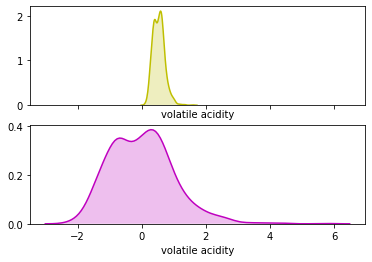

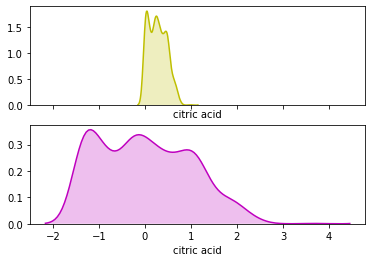

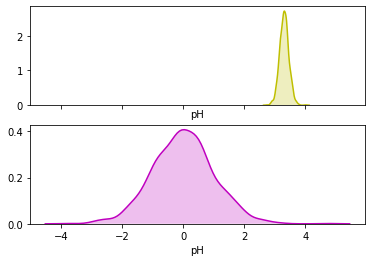

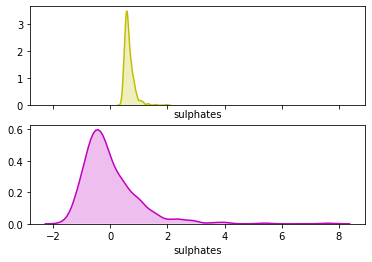

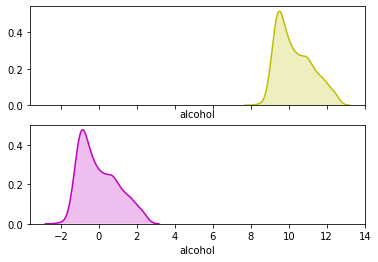

In [75]:
normed_train_data.columns
for columns in normed_train_data.columns:
  lineGraphComparision(train_dataset[columns], normed_train_data[columns])
  tableComparision(train_dataset, normed_train_data, columns)


In [76]:
normed_train_data.describe().transpose()

count          mean  std  ...       50%       75%       max
volatile acidity  1223.0  1.568111e-15  1.0  ... -0.008185  0.591884  5.719751
citric acid       1223.0  3.067229e-15  1.0  ... -0.075518  0.814498  3.687978
pH                1223.0 -3.448353e-14  1.0  ... -0.034331  0.631069  4.690012
sulphates         1223.0 -4.945621e-16  1.0  ... -0.225047  0.413140  7.781310
alcohol           1223.0  1.794912e-14  1.0  ... -0.213371  0.762963  2.390185

[5 rows x 8 columns]

# Define the function that builds model

In [0]:
def build_model(my_learning_rate):
  model = keras.Sequential([
    layers.Flatten(input_shape=[(len(train_dataset.keys()))]),
    layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    layers.Dense(3),
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=my_learning_rate)

  model.compile(optimizer=optimizer,
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

# Build and train the model

In [78]:
# Hyperparameters
EPOCHS = 200
learning_rate = 0.01

model = build_model(learning_rate)
print(model.summary())

checkpoint_path = "/content/gdrive/My Drive/Trained_Models/wine_binary_quality/wine_binary_quality.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, 
  validation_split = 0.2, 
  # callbacks=[cp_callback],
  )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 1,155
Trainable params: 1,155
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
31/31 [==============================] - 0s 4ms/step - loss: 0.5356 - accuracy: 0.8098 - val_loss: 0.4935 - val_accuracy: 0.8122
Epoch 2/200
31/31 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.8487 - val

In [79]:
test_loss, test_acc = model.evaluate(
    normed_test_data, 
    test_labels, 
    verbose=2,
    )
print('Test accuracy:', test_acc)

10/10 - 0s - loss: 0.5141 - accuracy: 0.8693
Test accuracy: 0.8692810535430908


# Evaluate the model

In [0]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(normed_test_data)

# Export model to GDrive

In [0]:
#Graph to look at the full set of 3 class predictions

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Real Value :  1
Predicted Value :  1


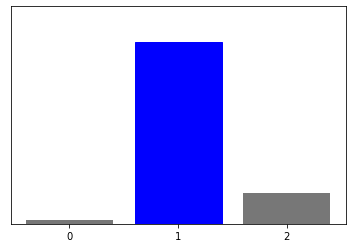

In [82]:
i = len(predictions)-2
array_test_labels = test_labels.to_numpy()

print("Real Value : ", array_test_labels[i])
print("Predicted Value : ", np.argmax(predictions[i]))
plot_value_array(i, predictions[i],  array_test_labels)

In [83]:
new_df = test_labels.copy()

new_df = new_df.reset_index()
del new_df["index"]
prediction_array = []

for prediction in predictions :
  prediction_array.append(np.argmax(prediction))
new_df["Rating Prediction"] = prediction_array
new_df.tail(20)

Rating  Rating Prediction
286       1                  1
287       1                  1
288       1                  1
289       1                  1
290       1                  1
291       1                  1
292       1                  1
293       1                  1
294       1                  1
295       2                  1
296       1                  1
297       1                  1
298       1                  1
299       1                  1
300       1                  1
301       1                  1
302       1                  1
303       1                  1
304       1                  1
305       1                  1

In [0]:
checkpoint_path = "/content/gdrive/My Drive/Trained_Models/wine_classifier/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [0]:
model.save_weights('/content/gdrive/My Drive/Trained_Models/wine_classifier/wine_quality_model')

In [0]:
model_save_name = 'wine_classifier'
save_model_path = '/content/gdrive/My Drive/Trained_Models/wine_classifier'

In [87]:
model.save(save_model_path)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Trained_Models/wine_classifier/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Trained_Models/wine_classifier/assets


In [0]:
model.save('/content/gdrive/My Drive/Trained_Models/wine_classifier/wine_classifier.h5') 

In [89]:
converter = tf.lite.TFLiteConverter.from_saved_model(save_model_path)
tflite_model = converter.convert()
open("/content/gdrive/My Drive/Trained_Models/wine_classifier/wine_classifier.tflite", "wb").write(tflite_model)

5704